## Tutorial 1: reading and preparing data for an HsM model

In this tutorial we will show you how to read data from :

1. Raw (preprocessed) EEG data in *.bdf* or *.fif* format
2. Data already transformed to PC space (e.g. previous applications of HsMM MVPA)

All these methods assume that the data has been preprocessed (e.g. see method section of [this paper](https://psyarxiv.com/nmg6w/)  for an example of preprocessing for HsMM-MVPA), if you don't know where to start for preprocessing EEG, the [MNE](https://mne.tools/stable/index.html) is full of tutorials on EEG data.

In [1]:
#Development only
#import sys
#sys.path.insert(0, "/home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/src")
#%load_ext autoreload
#%autoreload 2

# 1. Reading raw data

For the following I give an example using (yet not public) preprocessed EEG data that has not yet been epoched.

First in order for the HsMM to run on each trial we have to declare the stimulus triggers as well as the response triggers which defines a trial

In [2]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

Then we specify wich files we want to analyse, if for example you have all your participant dat inside one folder you can do the following :

In [3]:
import os
eeg_path = '../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/'#Where the data is relative to where you run the code on your computer
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(eeg_path) if 'preprocessed' in x]#select files which contain the string 'preprocessed'
subj_names = subj_names[:2]# Take two subjects for the illustration
subj_files = [eeg_path+ 'preprocessed_'+x+'_raw.fif' for x in subj_names]#Create a list of files that can be read from the folder

Next we can directly use the ```subj_file``` list and feed it to the ```hsmm.utils.read_mne_EEG``` but first you have to decide on a number of parameters regarding EEG processing, see the following helper of the function

In [4]:
from hsmm_mvpy import utils
utils.read_mne_EEG?

Signature:
utils.read_mne_EEG(
    pfiles,
    event_id,
    resp_id,
    sfreq,
    subj_idx=None,
    events_provided=None,
    verbose=True,
    tmin=-0.2,
    tmax=5,
    offset_after_resp=0.1,
    high_pass=0.5,
    low_pass=30,
    upper_limit_RT=5,
    lower_limit_RT=0.001,
    reject_threshold=None,
)
Docstring:
Reads EEG data format (.fif or .bdf) using MNE's integrated function .

Notes: 
- Only EEG data are selected (other channel types are discarded)
- All times are expressed on the second scale.
- If multiple files in pfiles the data of the group is read and seqentially processed.
- Reaction Times are only computed if response trigger is in the epoch window (determined by tmin and tmax)

Procedure:
1) the data is filtered with filters specified in low_pass and high_pass. Parameters of the filter are
    determined by MNE's filter function.
2) if no events is provided, detect events in stumulus channel and keep events with id in event_id and resp_id.
3) eventual downsamplin

In [5]:
import hsmm_mvpy as hsmm
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive 
tmin, tmax = -.25, 2 #window size for the epochs, from 250ms before the stimulus up to 2 seconds after
offset_after_resp = .05 #The epochs will be cropped to each epochs RTs, but we want to keep a few ms after the response in case some bumps are later
high_pass, low_pass = .5,  30 #The filtering bandwidth
lower_limit_RT, upper_limit_RT = .25, 2 #lower and upper limit for the RTs all values outside of this range are discarded

hsmm.utils.read_mne_EEG(subj_files, event_id, resp_id, sfreq, subj_idx=subj_names, tmin=tmin, tmax=tmax, offset_after_resp=offset_after_resp, 
                            high_pass=high_pass, low_pass =low_pass, lower_limit_RT=lower_limit_RT, upper_limit_RT=upper_limit_RT, 
                            verbose=False)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

Processing participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S10_raw.fif
Reading 0 ... 4814847  =      0.000 ...  4701.999 secs...
Downsampling to 100 Hz
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.25 and 2 seconds
2294 RTs kept of 2294 clean epochs
2269 trials were retained for participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S10_raw.fif
End sampling frequency is 100 Hz
Processing participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S18_raw.fif
Reading 0 ... 5106687  =      0.000 ...  4986.999 secs...
Downsampling to 100 Hz
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.25 and 2 seconds
2355 RTs kept of 2355 clean epochs
2349 trials were retained for participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S18_raw.fif
End sampling frequency is 100 Hz


<xarray.Dataset>
Dimensions:      (epochs: 2419, samples: 186, participant: 2, electrodes: 64)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2435 2436 2437 2438 2439 2440
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 179 180 181 182 183 184 185
  * electrodes   (electrodes) <U3 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) <U3 'S10' 'S18'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 1.139e-05...
    event        (participant, epochs) <U16 'accuracy/right/3' ... 'speed/lef...
Attributes:
    sfreq:    100.0

And finally to keep track of sensor location we just mount the appropriate defaul layout for the future topologies we are going to plot

In [6]:
import mne 
raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position
raw.set_montage(mne.channels.make_standard_montage('biosemi64'));

# 2. Data already transformed to PC space (e.g. previous applications of HsMM MVPA)


This part is addressed mainly for researchers wanting to replicate previous findings with matlab with data that has already been turned into principal component space.

For this example we will use the data from the study by Anderson, Zhang, Borst, & Walsh ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) that you can download here: http://www.ai.rug.nl/~jpborst/modelbasedneuro/analysis_data_model.zip

First we read the .mat data file using ```scipy```

In [7]:
import scipy
import numpy as np

mat = scipy.io.loadmat('../matlab/analysis_data_model/data/varForBumps135_100.mat')#Where the .mat file with all the data and necessary infos is
data = np.array(mat['normedscore10'])# The data in PC space
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

Here we will adapt the structure of the matlab data to the expected data format

In [8]:
### Recovering RTs, trials and participants
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)


# creating data watrix with participant x trial x max duration x electrodes/comp
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.shape(data)[1], np.max(durations)))
conditions = np.tile(np.nan, (len(participant), np.max(trials)))
for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :,:durations[trial],] = data[limits[trial]:limits[trial+1]].T
    conditions[subjects[trial], within_trial] = mat['conds'][trial]

unstacked_data = hsmm.utils.hsmm_data_format(unstacked_data, conditions, sfreq=100, participants=participant)#converting to xarray
unstacked_data = unstacked_data.rename({'electrodes':'component'})#Data is already on PC space so no need to use the transform function
unstacked_data.to_netcdf('unstacked_data.nc')#saving the converted data

Now the data is in the expected format for HsMM_MVpy however we still need to recover the electrodes position

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


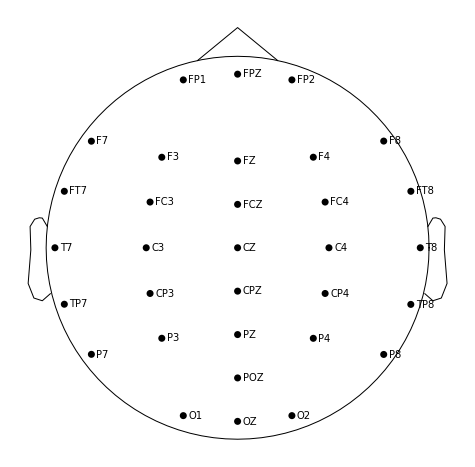

In [9]:
channels_loc = scipy.io.loadmat('../matlab/analysis_data_model/analysis/HSMM_code/chanlocs.mat')#Channel location 
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]#Dictionnary with x,y,z positions
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
        
from mne import channels#

montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
montage.plot();
np.save('positions',positions)#saving the positions

Everything is now ready to be used in hsmm_mvpy, e.g. see tutorial 3 that uses the data we just extracted